# OPA interferometry

<hr>

The relative phase stability of our OPAs is a crucial detail to how our experiments work. It has always been 'common sense' that the OPAs have random relative phase on the shot-to-shot timescale. 

This ipython notebook presents empirical evidence that shows that the random phase assumption is very poor.

In [1]:
#import external packages

import os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

import WrightTools as wt
Artist = wt.artists.mpl_2D

In [2]:
#define filepaths

folderpath = os.getcwd()
datafolder = os.path.join(folderpath, '2014.04.10 data')

### interference against delay

First we scan delay between the two beams. I started with OPA2 against itself (2 and 2') to get an idea of what a phase stable case looks like. The beams enter into the monochromator colinearly.

Here, each acquisition on the array let in 10 laser shots. The entire scan took about one minute to complete

Slit width for all of this data - 50 microns

data has only positive sign
lower and upper bounds: -0.462387538835 2.57773417487
labels failed to print
plotting finished!


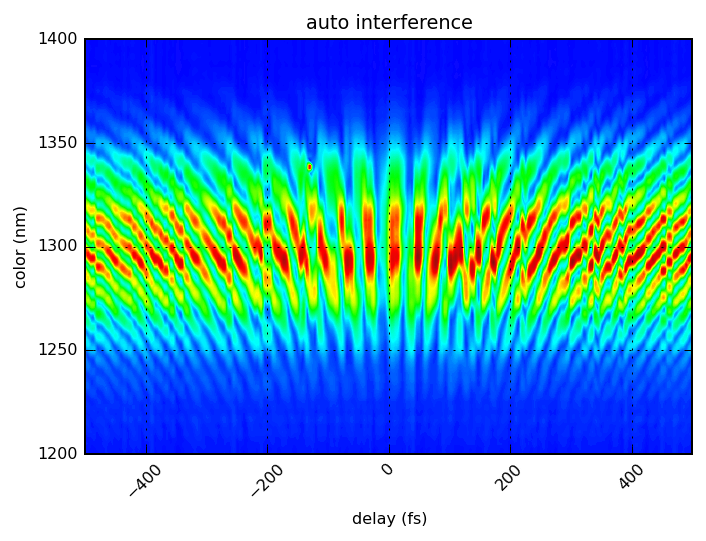

In [8]:
filepath = os.path.join(datafolder, 'auto interferometry (1) 0 ms wait [1x201] Delay.dat')
data = wt.data.from_dat(filepath, 'd1', 'wa', verbose = False)
artist = Artist()
artist.font_size = 8
artist.plot(data, xaxis = 0, yaxis = 1, channel = 4)
plt.title('auto interference')
plt.ylim(1200, 1400)
plt.xlabel('delay (fs)')
plt.ylabel('color (nm)')

Next I looked at 1 vs 2.

data has only positive sign
lower and upper bounds: -0.478587211355 4.25177075776
labels failed to print
plotting finished!


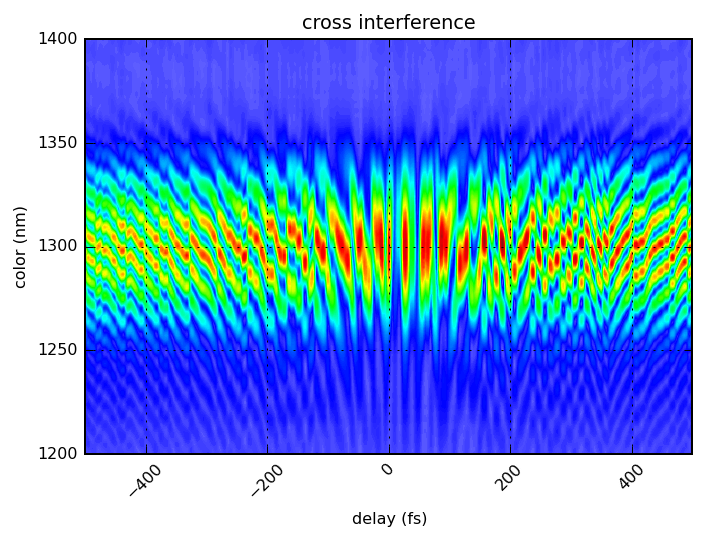

In [14]:
filepath = os.path.join(datafolder, 'cross interferometry (2) 0 ms wait [1x201] Delay.dat')
data = wt.data.from_dat(filepath, 'd2', 'wa', verbose = False)
artist = Artist()
artist.font_size = 8
artist.plot(data, 0, 1, 4)
plt.title('cross interference')
plt.ylim(1200, 1400)
plt.xlabel('delay (fs)')
plt.ylabel('color (nm)')

The above plot alone demonstrates that there is some amount of phase stability between OPA1 and OPA2 (remember - each acquisition is 10 shots). The jitter is there more, but it's still small compared to the beat pattern.

For the remainder of this notebook I focus on the cross interference case. In most cases I work at -500 fs.

### interference over time

Does the difference phase drift over time? If so, can we measure that drift?

These experiments measure the interference at exactly one shot at each position in lab time.

In [ ]:
filepath = os.path.join(datafolder, 'high res (1) 1 shots 100 ms wait [1000] Capture.dat')
data = wt.data.from_dat(filepath, 'num', 'wa')
data.axes[0].points *= 430./1000.

In [ ]:
artist = Artist()
artist.font_size = 8
artist.plot(data, 0, 1, 4)
plt.title('over time')
plt.xlabel('lab time (s)')
plt.ylabel('color (nm)')
plt.ylim(1200, 1400)

Now lets extract the phase from each time point so we can plot the phase over time.

Here is a representitive slice along color.

In [ ]:
xi = data.axes[1].points
zi = data.zis[4, :, 0] - np.average(data.zis[4, 0:10, 0])

plt.plot(xi, zi)
plt.xlim(1200, 1400)
plt.grid()
plt.xlabel('color (nm)')
plt.ylabel('signal (au)')

Now let's define a function to fit that data so we can extrat the phase.

In [ ]:
def function(p, x):
    A, mu, sigma, offset, B, freq, phase, C = p
    gauss_part = (A*np.exp(-(x-mu)**2 / (2*np.abs(sigma)**2)) - offset)
    sin_part = B*np.sin(x*freq + phase)
    return gauss_part + C*gauss_part*sin_part

def residuals(p, y, x):
    # force sigma to be positive
    err = y-function(p, x)
    return err

import scipy

p0 = np.array([0.2,   #gauss amplitude
               1300., #gauss mean
               30.,   #gauss stdev
               0,     #offset
               0.2,   #sin amplitude
               0.5,   #sin frequency
               0,     #sin phase
               0.5])  #part that is sin

out = p0.copy()
out = scipy.optimize.leastsq(residuals, p0, args=(zi, xi))[0]
zfit = function(out, xi)

freq_static = out[5]

plt.plot(xi, zi)
plt.plot(xi, zfit)
plt.xlim(1200, 1400)
plt.grid()
plt.xlabel('color (nm)')
plt.ylabel('signal (au)')
plt.legend(['data', 'fit'], loc = 'best')

great now let's do it for all times

In [ ]:
def function(p, x):
    A, mu, sigma, offset, B, freq, phase, C = p
    gauss_part = (A*np.exp(-(x-mu)**2 / (2*np.abs(sigma)**2)) - offset)
    sin_part = abs(B)*np.sin(x*freq_static + phase)
    return gauss_part + abs(C)*gauss_part*sin_part

t = data.axes[0].points
outs = np.zeros([len(data.zis[4, 0]), len(p0)]) 
for i in range(len(data.zis[4, 0])): 
    xi = data.axes[1].points
    zi = data.zis[4, :, i] - np.average(data.zis[4, 0:10, i])
    outs[i] = scipy.optimize.leastsq(residuals, p0, args=(zi, xi))[0]
    


In [ ]:
plt.plot(t, np.fmod(outs[:, 6],np.pi))
plt.grid()
plt.ylabel('rad')
plt.xlabel('time')

There is more data to work up, including the reproducability with OPA motor position and interference between different colors.

A better treatment of phase is also deserved, so that we can understand the data that was collected over many hours.

I will work this stuff up, but it just cannot be top priority right now.